# Working with PyBaMM Models

PyProBE has bidirectional integration with the popular open-source battery modelling software PyBaMM. This means:
- PyBaMM simulations can be run from experiment details provided in the README file
- PyBaMM solutions can be read by PyProBE and displayed alongside experimental data

This example will demonstrate both of these features. We will start by loading some experimental data for the LG M50 cell, which is well parameterised in the literature [1] and has a large associated degradation dataset [2].

In [1]:
%%capture
%pip install pybamm
%pip install matplotlib
%pip install ipywidgets

In [2]:
import matplotlib.pyplot as plt
import pybamm

import pyprobe

%matplotlib inline

In [3]:
cell = pyprobe.Cell(info={"Model": "LG M50"})

data_directory = "../../../tests/sample_data/LGM50"

cell.add_procedure(
    procedure_name="BoL RPT",
    folder_path=data_directory,
    filename="NDK - LG M50 deg - exp 2,2 - rig 3 - 25degC - cell C - BoL - RPT0_short_CA4.parquet",
)

Alongside this procedure is a README.yaml file:

In [4]:
with open(data_directory + "/README.yaml", "r") as file:
    readme = file.read()
    print(readme)

Initial Charge:
  Steps: 
    0: Rest for 2 minutes
    1: Charge at 1.5 A until 4.2 V
    2: Hold at 4.2 V until 0.05 A 
    3: Rest for 2 hours
pOCV:
  Steps: 
    4: Rest for 30 seconds
    5: Discharge at 0.5 A until 2.5 V
    6: Rest for 6 hours
    7: Rest for 30 seconds
    8: Charge at 0.5 A until 4.2 V
    9: Rest for 10 minutes


The step descriptions in the readme file are PyBaMM experiment strings. PyProBE `RawData` objects include a `pybamm_experiment` property that parses the README into a format that can be passed to a `pybamm.Experiment` constructor:

interactive(children=(FloatSlider(value=0.0, description='t', max=30.169758183030183, step=0.3016975818303018)…

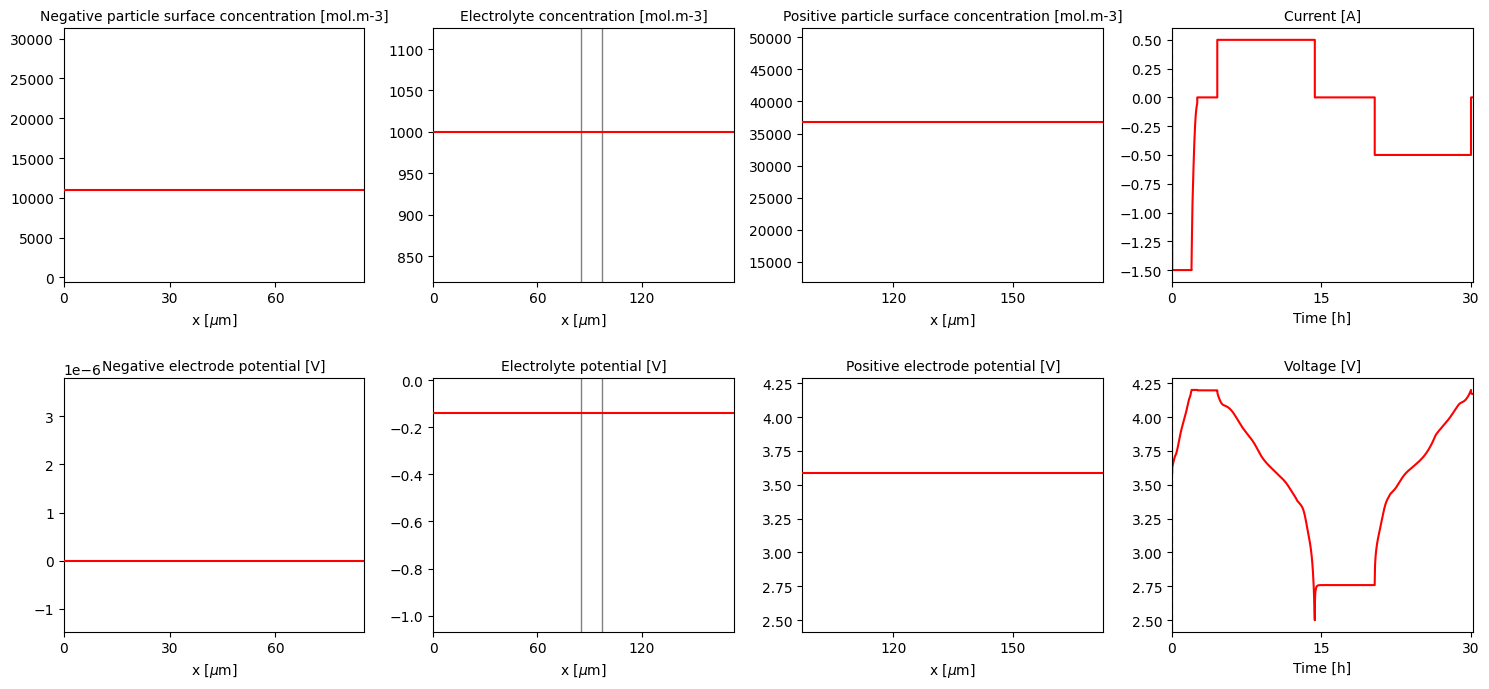

In [5]:
experiment = pybamm.Experiment(
    cell.procedure["BoL RPT"].pybamm_experiment,
    temperature=298.15,
)
model = pybamm.lithium_ion.DFN()
parameters = pybamm.ParameterValues("ORegan2022")
sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameters)
solution = sim.solve(initial_soc=0.35)
solution.plot()

Having solved the solution, we can import it back into PyProBE to display the model solution alongside the experimental data:

<Axes: xlabel='Time [s]'>

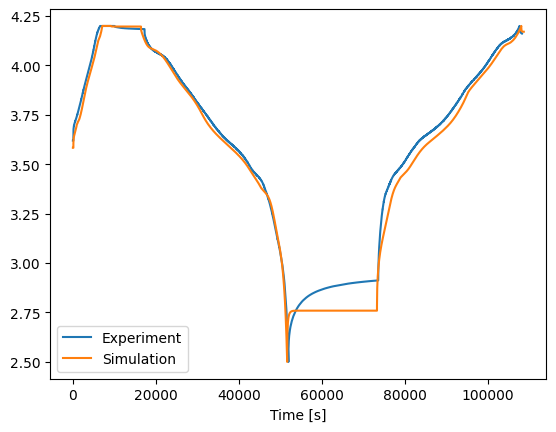

In [6]:
cell.import_pybamm_solution("BoL RPT DFN", ["BoL RPT"], solution)

fig, ax = plt.subplots()
cell.procedure["BoL RPT"].plot("Time [s]", "Voltage [V]", ax=ax, label="Experiment")
cell.procedure["BoL RPT DFN"].plot("Time [s]", "Voltage [V]", ax=ax, label="Simulation")

The `pybamm_experiment` property can be called on any filtered section of the data in PyProBE:

<Axes: xlabel='Step Time [s]'>

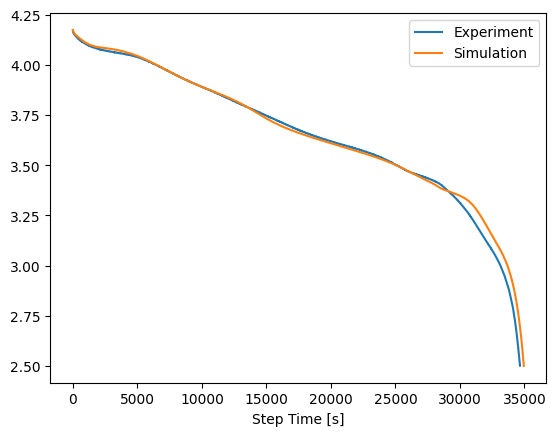

In [7]:
discharge_experiment = pybamm.Experiment(
    cell.procedure["BoL RPT"].discharge(0).pybamm_experiment,
    temperature=298.15,
)
sim = pybamm.Simulation(
    model, experiment=discharge_experiment, parameter_values=parameters
)
solution = sim.solve()

cell.import_pybamm_solution("BoL RPT DFN", ["Discharge only"], solution)

fig, ax = plt.subplots()
cell.procedure["BoL RPT"].discharge(0).plot(
    "Step Time [s]", "Voltage [V]", ax=ax, label="Experiment"
)
cell.procedure["BoL RPT DFN"].discharge(0).plot(
    "Step Time [s]", "Voltage [V]", ax=ax, label="Simulation"
)

1. O’Regan K, Brosa Planella F, Widanage WD, Kendrick E. Thermal-electrochemical parameters of a high energy lithium-ion cylindrical battery. Electrochimica Acta. 2022;425: 140700. https://doi.org/10.1016/J.ELECTACTA.2022.140700.
2. Kirkaldy N, Samieian MA, Offer GJ, Marinescu M, Patel Y. Lithium-ion battery degradation: Comprehensive cycle ageing data and analysis for commercial 21700 cells. Journal of Power Sources. 2024;603: 234185. https://doi.org/10.1016/j.jpowsour.2024.234185.